# 1 - Importing libraries

In [1]:
import numpy as np
import gymnasium as gym
import panda_gym
import torch
import matplotlib.pyplot as plt
import os
import json
from utils import create_directory, print_env_info, save_training_data
from sac import SAC
from td3 import TD3
from random_search import run_random_search
from IPython.display import clear_output, display
import warnings

warnings.filterwarnings('ignore')

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up directory structure
create_directory("./results")
create_directory("./results/random_search")
create_directory("./results/random_search/sac")
create_directory("./results/random_search/td3")
create_directory("./results/random_search_her")
create_directory("./results/random_search_her/sac")
create_directory("./results/random_search_her/td3")

# Define environment
ENV_NAME = "PandaReach-v3"

# Print environment information
env = gym.make(ENV_NAME)
print_env_info(env)
env.close()


---------------------------------------
Environment: PandaReach-v3
Observation Space: Dict('achieved_goal': Box(-10.0, 10.0, (3,), float32), 'desired_goal': Box(-10.0, 10.0, (3,), float32), 'observation': Box(-10.0, 10.0, (6,), float32))
Action Space: Box(-1.0, 1.0, (3,), float32)
Action Space High: [1. 1. 1.]
Action Space Low: [-1. -1. -1.]
---------------------------------------


# 2 - Helper functions

In [2]:


def run_training(algorithm='both', use_her=False, her_strategy="future", her_k=4, n_trials=5, max_timesteps=30000):
    
    print(f"Using device: {device}")
    
    # Determine which algorithms to run
    algorithms = []
    if algorithm == 'both':
        algorithms = ['sac', 'td3']
    elif algorithm == 'sac':
        algorithms = ['sac']
    elif algorithm == 'td3':
        algorithms = ['td3']
    elif algorithm == 'sac_her':
        algorithms = ['sac']
        use_her = True
    elif algorithm == 'td3_her':
        algorithms = ['td3']
        use_her = True
    elif algorithm == 'both_her':
        algorithms = ['sac', 'td3']
        use_her = True
    else:
        print(f"Invalid algorithm: {algorithm}")
        return None
    
    # Set up save directory based on whether HER is used
    save_dir = "./results/random_search_her" if use_her else "./results/random_search"
    
    # Run random search
    print("====================")
    print(f"Running random search for {', '.join(algorithms)}" + (" with HER" if use_her else ""))
    print("====================")
    
    results = run_random_search(
        n_trials=n_trials,
        max_timesteps=max_timesteps,
        save_dir=save_dir,
        use_her=use_her,
        her_strategy=her_strategy,
        her_k=her_k,
        algorithms=algorithms,
        device=device
    )
    
    # Load best parameters
    best_params_path = f"{save_dir}/best_params{'_her' if use_her else ''}.json"
    
    if os.path.exists(best_params_path):
        with open(best_params_path, 'r') as f:
            best_params = json.load(f)
            
        # Print best parameters
        for alg in algorithms:
            if alg in best_params:
                print(f"\n==== Best {alg.upper()}" + (" + HER" if use_her else "") + f" Parameters ====")
                print(f"Success Rate: {best_params[alg]['success_rate']}")
                for param, value in best_params[alg]['params'].items():
                    print(f"{param}: {value}")
    
    return results



In [3]:
def run_multiple_algorithms(algorithms=['sac', 'td3', 'sac_her', 'td3_her'], her_strategy="future", her_k=4, n_trials=3, max_timesteps=30000):
    
    comparison_results = {}
    
    # Run each algorithm
    for alg in algorithms:
        print(f"\n==== Running {alg.upper()} ====")
        use_her = 'her' in alg
        base_alg = alg.replace('_her', '')
        
        # Run training
        results = run_training(
            algorithm=alg,
            use_her=use_her,
            her_strategy=her_strategy,
            her_k=her_k,
            n_trials=n_trials,
            max_timesteps=max_timesteps
        )
        
        # Store best result for this algorithm
        if results:
            if base_alg == 'sac' and results.get('sac_results'):
                comparison_results[alg] = max(results['sac_results'], 
                                             key=lambda x: x['final_success_rate'])
            elif base_alg == 'td3' and results.get('td3_results'):
                comparison_results[alg] = max(results['td3_results'],
                                             key=lambda x: x['final_success_rate'])
            elif base_alg == 'both':
                if results.get('sac_results'):
                    comparison_results['sac' + ('_her' if use_her else '')] = max(
                        results['sac_results'], key=lambda x: x['final_success_rate'])
                if results.get('td3_results'):
                    comparison_results['td3' + ('_her' if use_her else '')] = max(
                        results['td3_results'], key=lambda x: x['final_success_rate'])
    
    return comparison_results



In [4]:
def plot_comprehensive_comparison(comparison_results, save_path="./results/comprehensive_comparison.png"):
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Define unique colors for each algorithm+strategy combination
    base_colors = {
        'sac': {'baseline': 'blue', 'final': 'green', 'future': 'purple', 'random': 'cyan'},
        'td3': {'baseline': 'red', 'final': 'orange', 'future': 'brown', 'random': 'pink'}
    }
    
    strategy_styles = {
        'baseline': {'linestyle': '-', 'alpha': 1.0},
        'final': {'linestyle': '-', 'alpha': 0.9},
        'future': {'linestyle': '-', 'alpha': 0.9},
        'random': {'linestyle': '-', 'alpha': 0.9}
    }
    
    # Create styles for all possible algorithm combinations
    styles = {}
    for alg_name in comparison_results.keys():
        # Extract base algorithm (sac or td3)
        if 'sac' in alg_name.lower():
            base_alg = 'sac'
            base_alg_label = 'SAC'
        elif 'td3' in alg_name.lower():
            base_alg = 'td3'
            base_alg_label = 'TD3'
        else:
            base_alg = 'sac'  # fallback
            base_alg_label = 'Unknown'
        
        # Extract strategy
        if 'baseline' in alg_name.lower():
            strategy = 'baseline'
            label = f'{base_alg_label}'
        elif 'final' in alg_name.lower():
            strategy = 'final'
            label = f'{base_alg_label}+HER(Final)'
        elif 'future' in alg_name.lower():
            strategy = 'future'
            label = f'{base_alg_label}+HER(Future)'
        elif 'random' in alg_name.lower():
            strategy = 'random'
            label = f'{base_alg_label}+HER(Random)'
        else:
            strategy = 'baseline'
            label = alg_name
        
        # Get unique color for this combination
        color = base_colors[base_alg][strategy]
        
        # Combine color with strategy style
        styles[alg_name.lower()] = {
            'color': color,
            'linestyle': strategy_styles[strategy]['linestyle'],
            'alpha': strategy_styles[strategy]['alpha'],
            'label': label
        }
    
    # Plot 1: Success rates over evaluations
    ax1 = axes[0, 0]
    for alg, result in comparison_results.items():
        if 'success_rates' in result and len(result['success_rates']) > 0:
            ax1.plot(range(len(result['success_rates'])), result['success_rates'], 
                     **styles[alg.lower()])
    ax1.set_xlabel('Evaluation Step')
    ax1.set_ylabel('Success Rate')
    ax1.set_title('Success Rate vs Evaluation Step')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Rewards over episodes
    ax2 = axes[0, 1]
    for alg, result in comparison_results.items():
        if 'rewards' in result and len(result['rewards']) > 0:
            # Smooth rewards if possible
            if len(result['rewards']) > 10:
                window_size = min(10, len(result['rewards']) // 5)
                weights = np.ones(window_size) / window_size
                smoothed = np.convolve(result['rewards'], weights, mode='valid')
                ax2.plot(range(len(smoothed)), smoothed, **styles[alg.lower()])
            else:
                ax2.plot(range(len(result['rewards'])), result['rewards'], **styles[alg.lower()])
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Average Reward')
    ax2.set_title('Episode Reward vs Episode')
    ax2.legend()
    ax2.grid(True)
    
    # Plot 3: Episode lengths over episodes
    ax3 = axes[0, 2]
    for alg, result in comparison_results.items():
        if 'episode_lengths' in result and len(result['episode_lengths']) > 0:
            # Smooth episode lengths if possible
            if len(result['episode_lengths']) > 10:
                window_size = min(10, len(result['episode_lengths']) // 5)
                weights = np.ones(window_size) / window_size
                smoothed = np.convolve(result['episode_lengths'], weights, mode='valid')
                ax3.plot(range(len(smoothed)), smoothed, **styles[alg.lower()])
            else:
                ax3.plot(range(len(result['episode_lengths'])), result['episode_lengths'], 
                         **styles[alg.lower()])
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Episode Length')
    ax3.set_title('Episode Length vs Episode')
    ax3.legend()
    ax3.grid(True)
    
    # Plot 4: Final success rates (bar chart)
    ax4 = axes[1, 0]
    algs = list(comparison_results.keys())
    success_rates = [result['final_success_rate'] for result in comparison_results.values()]
    colors = [styles[alg.lower()]['color'] for alg in algs]
    
    bars = ax4.bar(algs, success_rates, color=colors, alpha=0.7)
    ax4.set_xlabel('Algorithm')
    ax4.set_ylabel('Final Success Rate')
    ax4.set_title('Final Success Rate Comparison')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True)
    
    # Plot 5: Training time / convergence speed
    ax5 = axes[1, 1]
    steps_to_converge = []
    for alg, result in comparison_results.items():
        if 'success_rates' in result and len(result['success_rates']) > 1:
            # Define convergence as reaching 90% of final success rate
            threshold = 0.9 * result['final_success_rate']
            for i, rate in enumerate(result['success_rates']):
                if rate >= threshold:
                    steps_to_converge.append(i)
                    break
            else:
                steps_to_converge.append(len(result['success_rates']))
        else:
            steps_to_converge.append(0)
    
    bars = ax5.bar(algs, steps_to_converge, color=colors, alpha=0.7)
    ax5.set_xlabel('Algorithm')
    ax5.set_ylabel('Evaluations to Converge')
    ax5.set_title('Convergence Speed')
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(True)
    
    # Plot 6: Average episode length
    ax6 = axes[1, 2]
    avg_lengths = []
    for result in comparison_results.values():
        if 'episode_lengths' in result and len(result['episode_lengths']) > 0:
            # Average of last 10% of episodes
            cutoff = max(1, int(len(result['episode_lengths']) * 0.9))
            avg_lengths.append(np.mean(result['episode_lengths'][cutoff:]))
        else:
            avg_lengths.append(0)
    
    bars = ax6.bar(algs, avg_lengths, color=colors, alpha=0.7)
    ax6.set_xlabel('Algorithm')
    ax6.set_ylabel('Avg Episode Length')
    ax6.set_title('Final Average Episode Length')
    ax6.tick_params(axis='x', rotation=45)
    ax6.grid(True)
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    
    return fig

# 3 - Running the main algorithm

=== Running Comprehensive Algorithm Comparison ===

1. Testing Baseline Algorithms (No HER):

==== Running SAC ====
Using device: cpu
Running random search for sac
---------------------------------------
Environment: PandaReach-v3
Observation Space: Dict('achieved_goal': Box(-10.0, 10.0, (3,), float32), 'desired_goal': Box(-10.0, 10.0, (3,), float32), 'observation': Box(-10.0, 10.0, (6,), float32))
Action Space: Box(-1.0, 1.0, (3,), float32)
Action Space High: [1. 1. 1.]
Action Space Low: [-1. -1. -1.]
---------------------------------------

==== Running Random Search for SAC ====

SAC Trial 1/2
Parameters: {'hidden_dim': 64, 'lr': 0.0005, 'gamma': 0.9662843816880992, 'tau': 0.005, 'alpha': 0.0682018400804, 'automatic_entropy_tuning': True, 'batch_size': 32, 'buffer_size': 50000, 'learning_starts': 0}
Episode 1: Total reward = -50.000, Length = 50
Episode 2: Total reward = -50.000, Length = 50
Episode 3: Total reward = -7.000, Length = 8
Episode 4: Total reward = -50.000, Length = 50


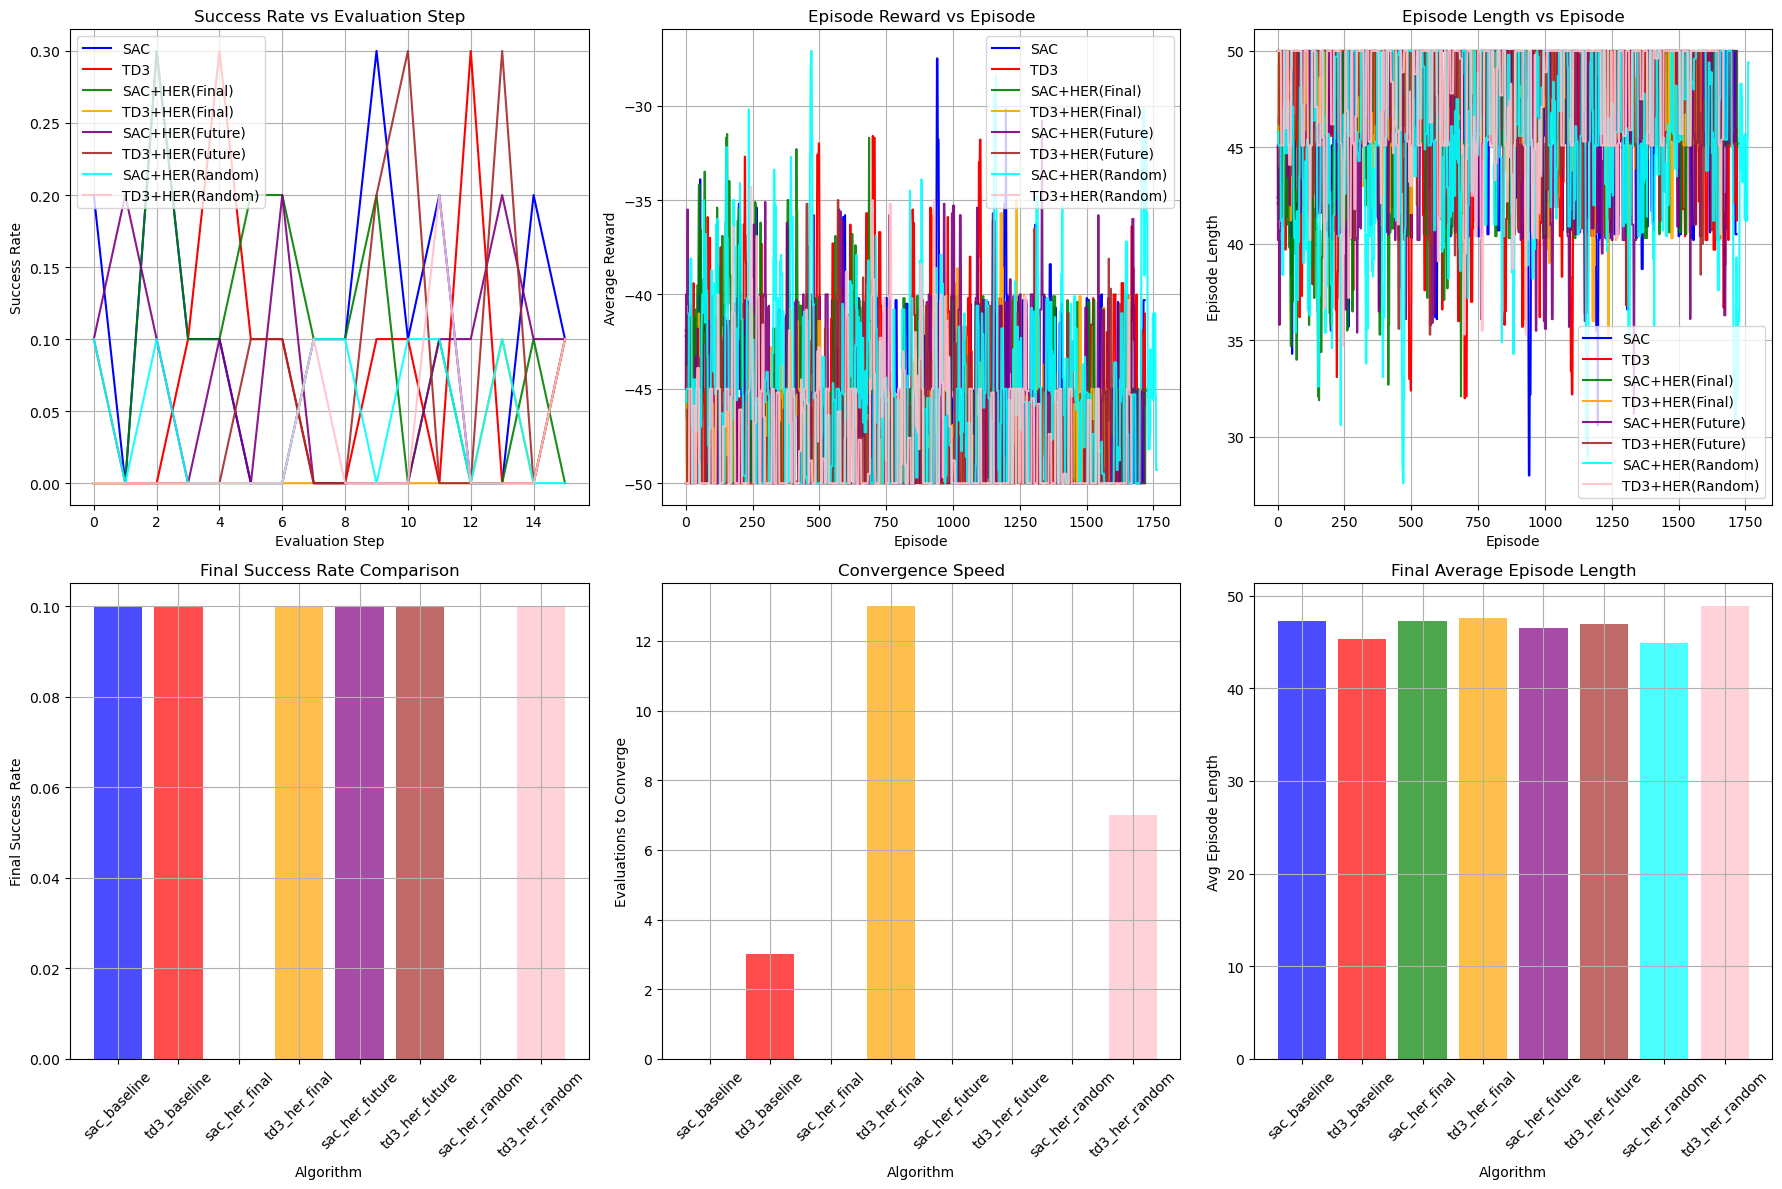

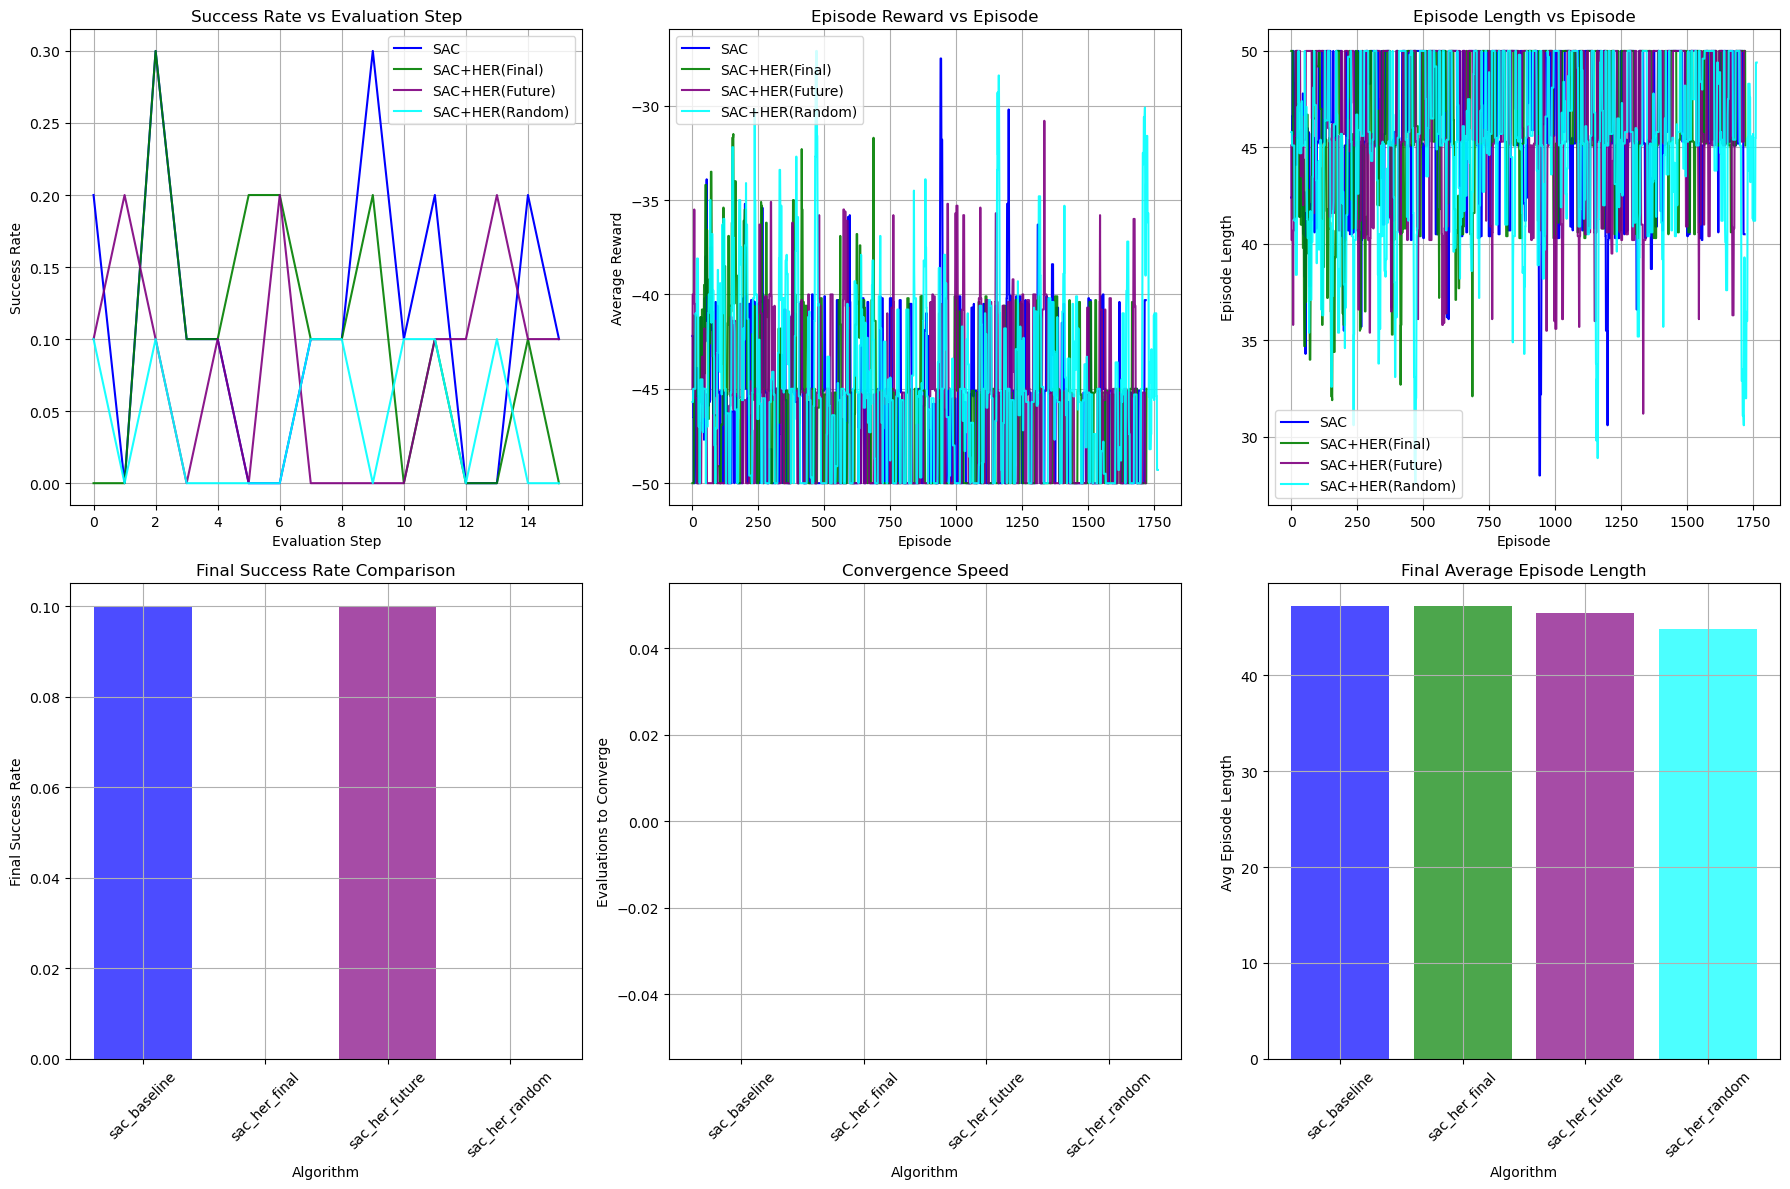

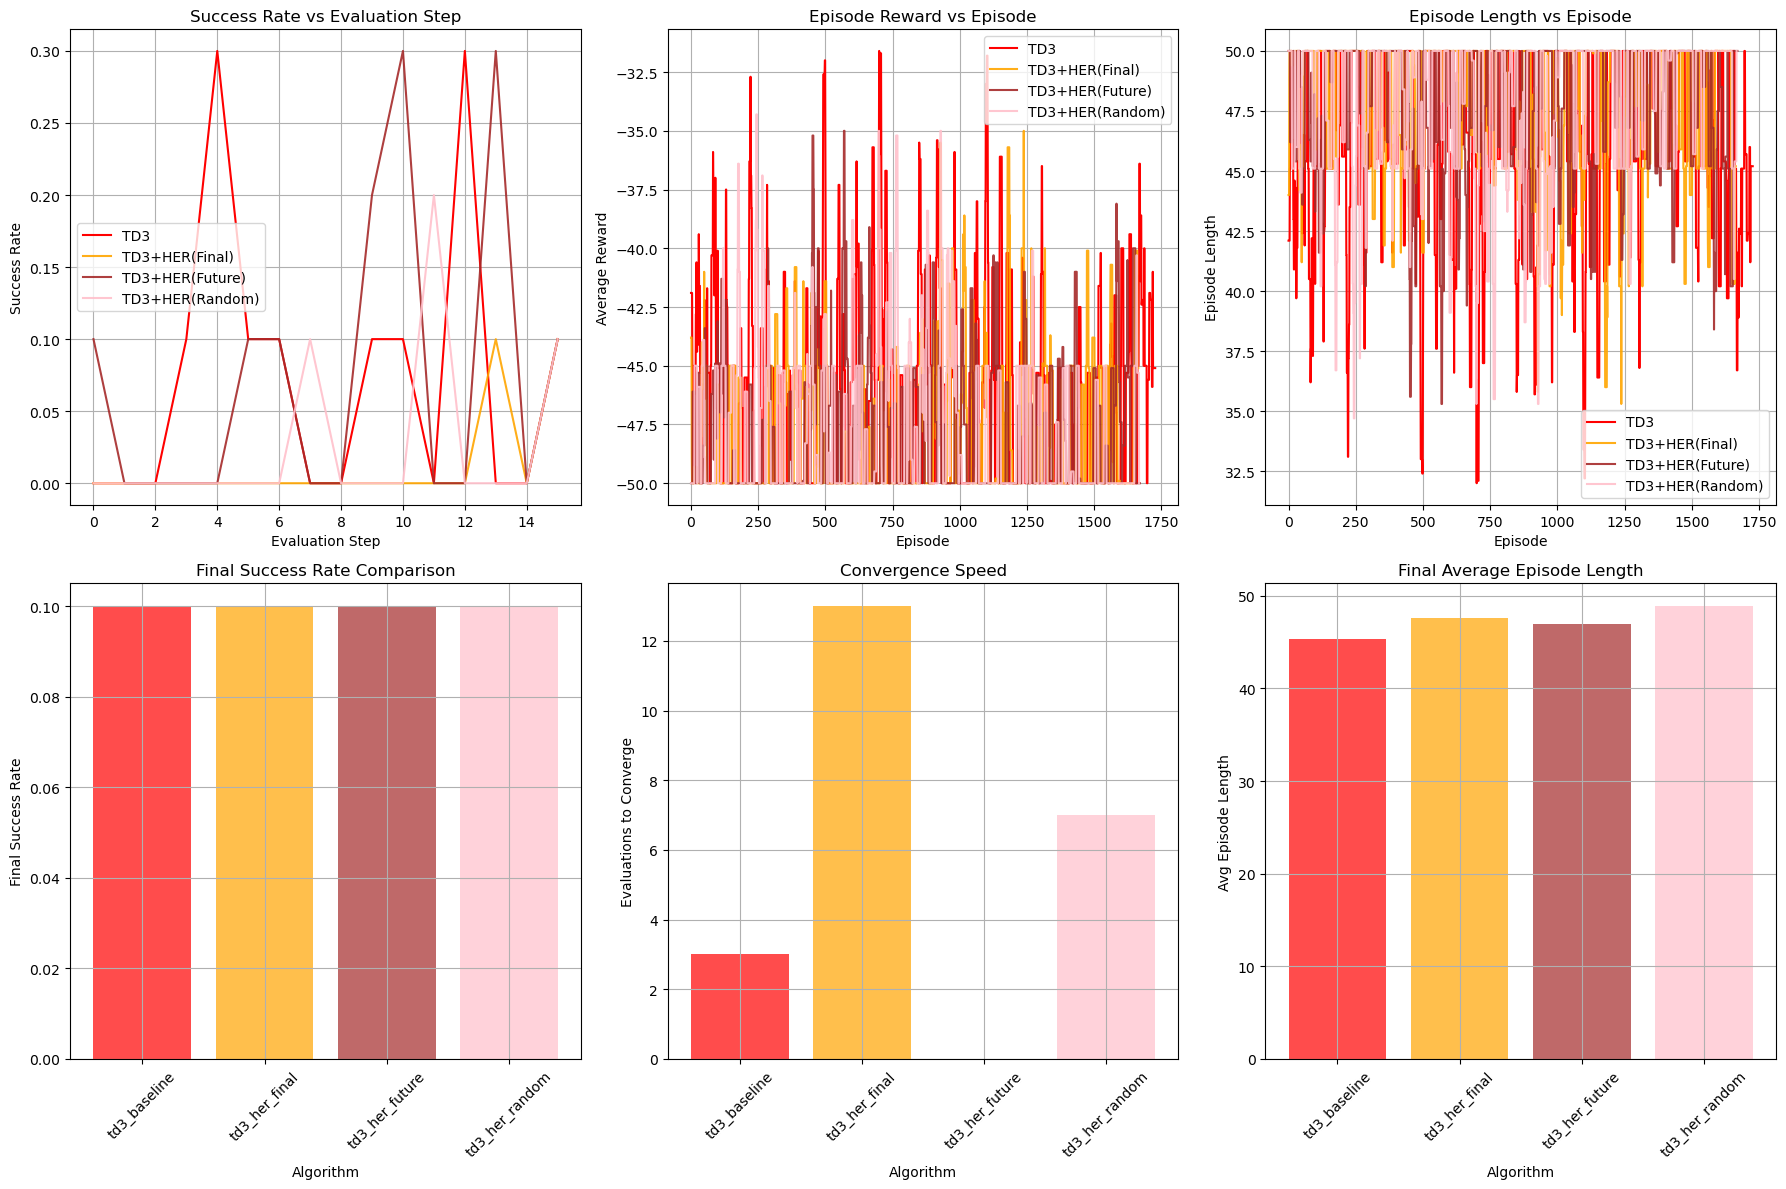


=== SUMMARY OF ALL EXPERIMENTS ===

1. Baseline Algorithms (No HER):
   sac: 0.100 success rate
   td3: 0.100 success rate

2. SAC with Different HER Strategies:
   sac_baseline: 0.100 success rate
   sac_her_final: 0.000 success rate
   sac_her_future: 0.100 success rate
   sac_her_random: 0.000 success rate

3. TD3 with Different HER Strategies:
   td3_baseline: 0.100 success rate
   td3_her_final: 0.100 success rate
   td3_her_future: 0.100 success rate
   td3_her_random: 0.100 success rate

=== BEST PERFORMERS ===
Best Overall: sac_baseline with 0.100 success rate
Best SAC: sac_baseline with 0.100 success rate
Best TD3: td3_baseline with 0.100 success rate

All experiments completed! Check the results directory for detailed plots.
Key files generated:
- ./results/comparison_all_strategies.png (All algorithms and strategies)
- ./results/comparison_sac_all_strategies.png (SAC baseline vs HER strategies)
- ./results/comparison_td3_all_strategies.png (TD3 baseline vs HER strategies)
-

In [5]:
if __name__ == "__main__":
    
    # First: Running baseline algorithms (no HER)
    print("\n1. Testing Baseline Algorithms (No HER):")
    baseline_results = run_multiple_algorithms(
        algorithms=['sac', 'td3'],
        n_trials=2,
        max_timesteps=80000
    )
    
    # Second: Test all HER strategies
    print("\n2. Testing All HER Strategies:")
    
    # HER with Final strategy
    print("\n  Testing Final Strategy HER:")
    final_her_results = run_multiple_algorithms(
        algorithms=['sac_her', 'td3_her'],
        her_strategy="final",
        her_k=4,
        n_trials=2,
        max_timesteps=80000
    )
    
    # HER with Future strategy  
    print("\n  Testing Future Strategy HER:")
    future_her_results = run_multiple_algorithms(
        algorithms=['sac_her', 'td3_her'],
        her_strategy="future",
        her_k=4,
        n_trials=2,
        max_timesteps=80000
    )
    
    # HER with Random strategy
    print("\n  Testing Random Strategy HER:")
    random_her_results = run_multiple_algorithms(
        algorithms=['sac_her', 'td3_her'],
        her_strategy="random",
        her_k=4,
        n_trials=2,
        max_timesteps=80000
    )
    
    # Combine all results for comprehensive comparison
    all_results = {}
    
    # Add baseline results
    for alg, result in baseline_results.items():
        all_results[f"{alg}_baseline"] = result
    
    # Add HER results with strategy names
    for alg, result in final_her_results.items():
        all_results[f"{alg}_final"] = result
    
    for alg, result in future_her_results.items():
        all_results[f"{alg}_future"] = result
        
    for alg, result in random_her_results.items():
        all_results[f"{alg}_random"] = result
    
    # Plot comprehensive comparison of all algorithms and strategies
    plot_comprehensive_comparison(all_results, save_path="./results/comparison_all_strategies.png")
    
    # Also create separate comparisons for easier analysis
    
    # SAC comparison: baseline vs all HER strategies
    sac_comparison = {}
    for alg_name, result in all_results.items():
        if 'sac' in alg_name:
            sac_comparison[alg_name] = result
    
    plot_comprehensive_comparison(sac_comparison, save_path="./results/comparison_sac_all_strategies.png")
    
    # TD3 comparison: baseline vs all HER strategies  
    td3_comparison = {}
    for alg_name, result in all_results.items():
        if 'td3' in alg_name:
            td3_comparison[alg_name] = result
    
    plot_comprehensive_comparison(td3_comparison, save_path="./results/comparison_td3_all_strategies.png")
    
    # Summary of all results
    print("\n=== SUMMARY OF ALL EXPERIMENTS ===")
    
    print("\n1. Baseline Algorithms (No HER):")
    for alg, result in baseline_results.items():
        print(f"   {alg}: {result['final_success_rate']:.3f} success rate")
    
    print("\n2. SAC with Different HER Strategies:")
    sac_strategies = {k: v for k, v in all_results.items() if 'sac' in k}
    for alg, result in sac_strategies.items():
        print(f"   {alg}: {result['final_success_rate']:.3f} success rate")
    
    print("\n3. TD3 with Different HER Strategies:")
    td3_strategies = {k: v for k, v in all_results.items() if 'td3' in k}
    for alg, result in td3_strategies.items():
        print(f"   {alg}: {result['final_success_rate']:.3f} success rate")
    
    # Find best performing configurations
    best_overall = max(all_results.items(), key=lambda x: x[1]['final_success_rate'])
    best_sac = max(sac_strategies.items(), key=lambda x: x[1]['final_success_rate'])
    best_td3 = max(td3_strategies.items(), key=lambda x: x[1]['final_success_rate'])
    
    print(f"\n=== BEST PERFORMERS ===")
    print(f"Best Overall: {best_overall[0]} with {best_overall[1]['final_success_rate']:.3f} success rate")
    print(f"Best SAC: {best_sac[0]} with {best_sac[1]['final_success_rate']:.3f} success rate")
    print(f"Best TD3: {best_td3[0]} with {best_td3[1]['final_success_rate']:.3f} success rate")